In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/GoEmotions4Labels/processed_all.csv


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
!pip install transformers

# Creating training datasets

In [4]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [5]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [6]:
DATA_COLUMN = "text"
LABEL_COLUMN = "emotion"

In [7]:
df_emotion = pd.read_csv("/kaggle/input/GoEmotions4Labels/processed_all.csv")

df_emotion = df_emotion[["text","emotion"]]  # we are interested in text and dialect only
df_emotion.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_emotion[LABEL_COLUMN].value_counts())

label_list_emotion = list(df_emotion[LABEL_COLUMN].unique())
print(label_list_emotion)

train_df_emotion, test_df_emotion = train_test_split(df_emotion, test_size=0.2, random_state=42, stratify=df_emotion[LABEL_COLUMN] )

print("Training length: ", len(train_df_emotion))
print("Testing length: ", len(test_df_emotion))

data_emotion = CustomDataset("emotion", train_df_emotion, test_df_emotion, label_list_emotion)

neutral    17568
anger       1850
joy         1713
sadness     1527
Name: emotion, dtype: int64
['neutral', 'anger', 'sadness', 'joy']
Training length:  18126
Testing length:  4532


# Trainer

In [8]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, BertModel,BertForSequenceClassification,
                          Trainer,TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [9]:
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now we need to check the tokenized sentence length to decide on the maximum sentence length value

Training Sentence Lengths: 


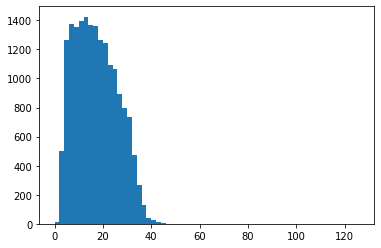

Testing Sentence Lengths: 


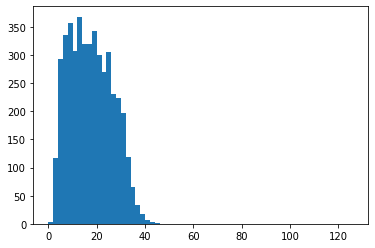

In [10]:
print("Training Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_emotion.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_emotion.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

In [11]:
max_len = 64

In [12]:
print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_emotion.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_emotion.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


Now let's create a classification dataset to load the data

In [13]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [14]:
label_map = { v:index for index, v in enumerate(data_emotion.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    data_emotion.train[DATA_COLUMN].to_list(),
    data_emotion.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    data_emotion.test[DATA_COLUMN].to_list(),
    data_emotion.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'neutral': 0, 'anger': 1, 'sadness': 2, 'joy': 3}


Check the dataset output

In [15]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[101, 2023, 2003, 2054, 3084, 2023, 4942, 2061, 7070, 1010, 4689, 1998, 4569, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=3)


In [16]:
def model_init():
    return BertForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

In [17]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    #print(classification_report(p.label_ids,preds))
    #print(confusion_matrix(p.label_ids,preds))
    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    #macro_precision = precision_score(p.label_ids,preds,average='macro')
    #macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
    }

In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=False # turned from True to False
    torch.backends.cudnn.benchmark = False

# Regular Training

In [20]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 32, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 3,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [21]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
#start the training
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 18126
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 2
  Total optimization steps = 849
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.318926,0.785070,0.894086
1,0.360500,0.310296,0.792539,0.896514
2,0.360500,0.325541,0.786720,0.888791


***** Running Evaluation *****
  Num examples = 4532
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-283
Configuration saved in ./train/checkpoint-283/config.json
Model weights saved in ./train/checkpoint-283/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4532
  Batch size = 128
***** Running Evaluation *****
  Num examples = 4532
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-849
Configuration saved in ./train/checkpoint-849/config.json
Model weights saved in ./train/checkpoint-849/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-566 (score: 0.7925389292109082).


TrainOutput(global_step=849, training_loss=0.29506019259790933, metrics={'train_runtime': 466.9959, 'train_samples_per_second': 116.442, 'train_steps_per_second': 1.818, 'total_flos': 1788003283642368.0, 'train_loss': 0.29506019259790933, 'epoch': 3.0})

Save the model, the tokenizer and the config

In [23]:
inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'neutral', 1: 'anger', 2: 'sadness', 3: 'joy'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json')

# Evaluating model over test dataset

In [24]:
pred_df = pd.DataFrame([])
pred_df[DATA_COLUMN] = data_emotion.test[DATA_COLUMN].copy()

In [25]:
max_len = 64

In [28]:
from transformers import pipeline
from tqdm import tqdm
pipe = pipeline("sentiment-analysis", model="./output_dir", device=0, return_all_scores =False, max_length=max_len, truncation=True)
preds = []
for s in tqdm(pred_df[DATA_COLUMN].to_list()):
    preds.append(pipe(s)[0]["label"])

loading configuration file ./output_dir/config.json
Model config BertConfig {
  "_name_or_path": "./output_dir",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "anger",
    "2": "sadness",
    "3": "joy"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 1,
    "joy": 3,
    "neutral": 0,
    "sadness": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration

In [29]:
pred_df["Prediction"] = preds
pred_df

,text,Prediction
22011,"So much to do, So much to see",neutral
4286,supa mario brothas 2 ya bitch,anger
22151,America will lose. You are mentally-deranged a...,neutral
10844,I like to think that this writer had one bad e...,neutral
18339,It does with PIA,neutral
...,...,...
2595,"""Sigh"" I thought you were better than this I t...",anger
13755,> Native Lithuanian Cool! Are you still there?...,neutral
9273,HURRY HARD!,neutral
4205,If your significant other had sex with someone...,neutral


Test accuracy = 0.896513680494263
              precision    recall  f1-score   support

     neutral       0.68      0.70      0.69       370
       anger       0.83      0.78      0.81       343
     sadness       0.93      0.95      0.94      3514
         joy       0.82      0.67      0.74       305

    accuracy                           0.90      4532
   macro avg       0.82      0.77      0.79      4532
weighted avg       0.90      0.90      0.90      4532



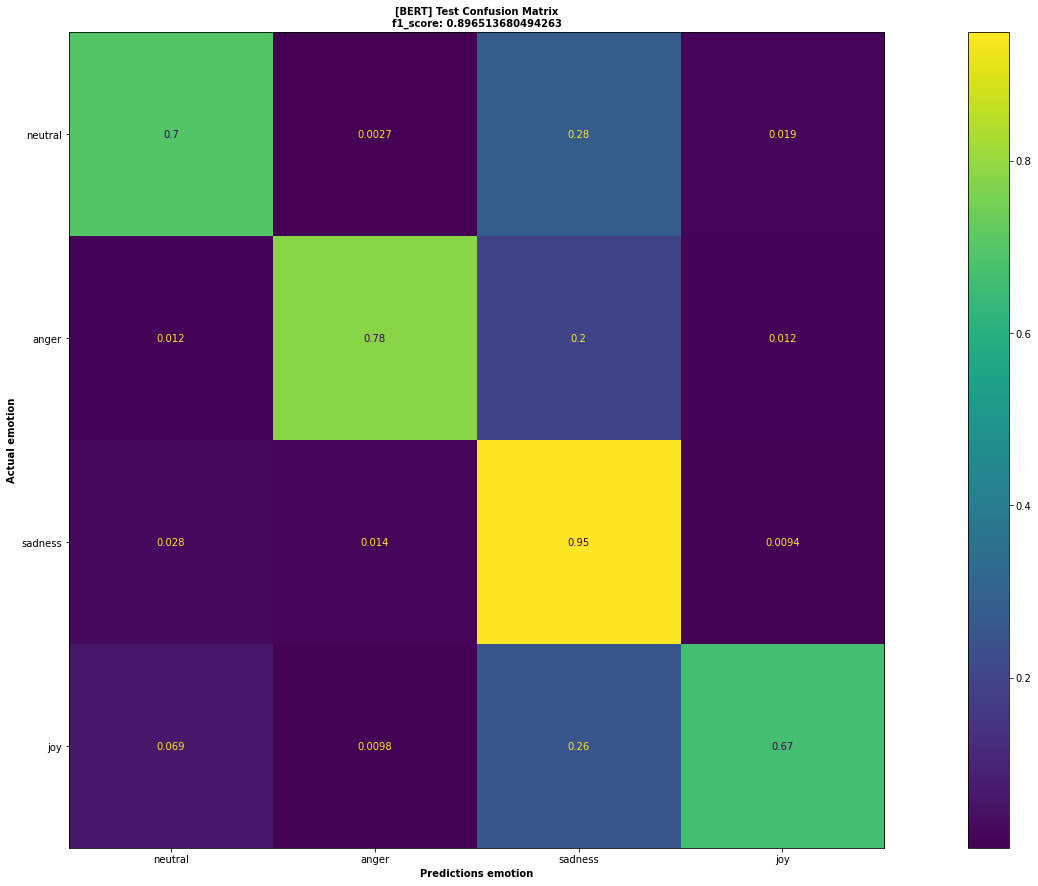

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test = data_emotion.test[LABEL_COLUMN]
y_test_pred = pred_df["Prediction"]
modelname = "BERT"

# Check test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

## Show results
print(classification_report(y_test, y_test_pred, target_names=label_list_emotion))

fig, ax = plt.subplots(1,1,figsize= (30,15))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred ,normalize ='true' ), display_labels=label_list_emotion).plot(ax=ax);
ax.set_title(f"[{modelname}] Test Confusion Matrix\nf1_score: {f1_score(y_test, y_test_pred, average='micro')}",font ={'weight' : 'bold'})
ax.set_xlabel('Predictions emotion',font ={'weight' : 'bold'})
ax.set_ylabel('Actual emotion',font ={'weight' : 'bold'})
plt.savefig(modelname+'_results.png', dpi=150, bbox_inches='tight')
plt.show()